# Resume Parsing

## 1. Load data

In [29]:
import pandas as pd
import numpy as np

df_resume = pd.read_csv("data/resume.csv")

In [30]:
df_resume.Category.unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

In [31]:
df_resume.shape

(2484, 4)

In [32]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000, ]
df_resume.shape

(1000, 4)

## 2. Load skill data

If we define patterns for all the skill, we gonna be too tired.

So spacy knows that, so it allows you to give you a list of words, then it will automatically create pattern.

In [33]:
import spacy

nlp = spacy.load('en_core_web_md')
skill_path = 'data/skills.jsonl'

In [34]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [35]:
doc = nlp("Chaky loves ajax.")
doc.ents

(Chaky, ajax)

## 3. Let's try to extract skills from this resume.csv

In [36]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
2044,28831442,PUBLIC RELATIONS OFFICER/ VICE-PRESID...,"<div class=""fontsize fontface vmargins hmargin...",PUBLIC-RELATIONS
2215,36905896,MEMBER SERVICES REPRESENTATIVE ...,"<div class=""fontsize fontface vmargins hmargin...",BANKING
1775,49127329,737 INDUSTRIAL ENGINEERING MANAGER ...,"<div class=""fontsize fontface vmargins hmargin...",ENGINEERING
1427,10653119,EXECUTIVE CHEF /CHEF MANAGER ...,"<div class=""LCA skn-cbg1 fontsize fontface vma...",CHEF
294,22776912,DIRECTOR OF INFORMATION TECHNOLOGY /C...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY


In [37]:
#clean our data
from spacy.lang.en.stop_words import STOP_WORDS

def preprocessing(sentence):
    stopwords    = list(STOP_WORDS)
    doc          = nlp(sentence)
    clean_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SYM' and \
            token.pos_ != 'SPACE':
                clean_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(clean_tokens)

In [38]:
random_resume = df_resume.Resume_str.iloc[5]
random_resume[:300]

'         SALES MANAGER       Professional Summary    Accomplished and energetic\xa0with a solid history of achievement in sales.\n Motivated leader with strong organizational and prioritization \nabilities. Areas of expertise include Meeting Goals, Negotiation and \nSelling to Customer Needs.      Interes'

In [39]:
preprocessing(random_resume[:300])

'sales manager professional summary accomplished energetic solid history achievement sale motivated leader strong organizational prioritization ability area expertise include meeting goals negotiation sell customer need intere'

In [40]:
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

In [41]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume
2044,28831442,PUBLIC RELATIONS OFFICER/ VICE-PRESID...,"<div class=""fontsize fontface vmargins hmargin...",PUBLIC-RELATIONS,public relation officer/ vice president summar...
2215,36905896,MEMBER SERVICES REPRESENTATIVE ...,"<div class=""fontsize fontface vmargins hmargin...",BANKING,member services representative summary skilled...
1775,49127329,737 INDUSTRIAL ENGINEERING MANAGER ...,"<div class=""fontsize fontface vmargins hmargin...",ENGINEERING,737 industrial engineering manager professiona...
1427,10653119,EXECUTIVE CHEF /CHEF MANAGER ...,"<div class=""LCA skn-cbg1 fontsize fontface vma...",CHEF,executive chef manager experience executive ch...
294,22776912,DIRECTOR OF INFORMATION TECHNOLOGY /C...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,director of information technology technology ...


## 4. Let's really extract skills!!

In [42]:
def get_skills(text):
    
    doc = nlp(text)
    
    skills = []
    
    for ent in doc.ents:
        if ent.label_ == 'SKILL':
            skills.append(ent.text)
            
    return skills

def unique_skills(x):
    return list(set(x))

In [64]:
def get_entities(resume):
    
    doc = nlp(resume)

    entities={}
    
    for entity in doc.ents:
        if entity.label_ in entities:
            entities[entity.label_].append(entity.text)
        else:
            entities[entity.label_] = [entity.text]
    for ent_type in entities.keys():
        entities[ent_type]=', '.join(unique_entities(entities[ent_type]))
    return entities

def unique_entities(x):
    return list(set(x))

In [43]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)

In [44]:
df_resume.Skills.iloc[0]

['spring']

## 5. Visualization

Which skills is most important in information management?

In [45]:
# set(df_resume.Category)

In [46]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(56, 6)

In [47]:
all_skills = np.concatenate(df_resume_it.Skills.values)

In [48]:
from collections import Counter, OrderedDict

counting = Counter(all_skills)
counting = OrderedDict(counting.most_common(10))

In [49]:
counting

OrderedDict([('support', 52),
             ('software', 48),
             ('design', 42),
             ('business', 41),
             ('server', 35),
             ('windows', 34),
             ('security', 33),
             ('database', 28),
             ('project management', 27),
             ('documentation', 24)])

<BarContainer object of 10 artists>

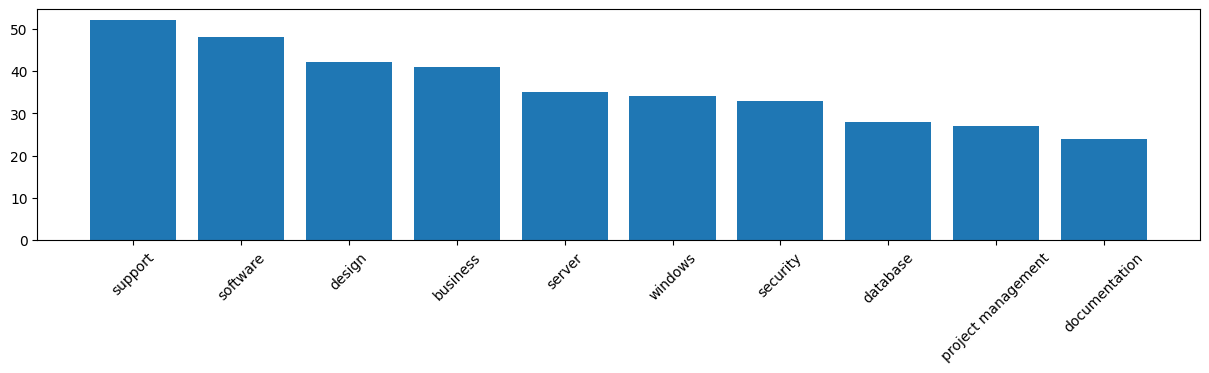

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.xticks(rotation=45)

plt.bar(counting.keys(), counting.values())

## 6. Name Entity Recognition

In [51]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[32]

In [52]:
doc = nlp(text)

In [80]:
# colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
# options = {"colors": colors}

# displacy.render(doc, style='ent', options=options)

## Task 1: Implementing additional features or improvements inspired by spaCy’s capabilities in natural language processing.

### Task 1.1 identify verbs with their corresponding subjects

In [68]:
from spacy.symbols import nsubj, VERB

# Finding a verb with a subject from below — good
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{develop, biomed, utilize, compare, gpa, develop, frameworks, utilize}


### Task 1.2  Identifies the root of the sentence, extracts the subject and its subtree

In [76]:
# Loop through the entire document
for sentence in doc.sents:
    # Find the root of the sentence
    roots = [token for token in sentence if token.head == token]
    
    if not roots:
        # Skip sentences without roots
        continue
    
    root = roots[0]
    
    # Extract the subject and its subtree
    subjects = list(root.lefts)
    
    if not subjects:
        # Skip roots without left children
        continue
    
    subject = subjects[0]
    
    # Print information about the subject and its descendants
    for descendant in subject.subtree:
        assert subject is descendant or subject.is_ancestor(descendant)
        print(descendant.text, descendant.dep_, descendant.n_lefts,
              descendant.n_rights,
              [ancestor.text for ancestor in descendant.ancestors])

chaklam compound 0 0 ['silpasuwanchai', 'email']
silpasuwanchai compound 1 0 ['email']
skill compound 0 0 ['•language', 'python', 'frameworks', 'develop']
•language compound 1 0 ['python', 'frameworks', 'develop']
python nsubj 1 0 ['frameworks', 'develop']
java compound 0 0 ['•tool', 'frameworks', 'develop']
•tool npadvmod 1 0 ['frameworks', 'develop']
frameworks nsubj 2 3 ['develop']
pytorch nmod 0 0 ['machine', 'frameworks', 'develop']
springboot nmod 0 0 ['machine', 'frameworks', 'develop']
•theory amod 0 0 ['machine', 'frameworks', 'develop']
machine dobj 3 1 ['frameworks', 'develop']
deep advmod 0 0 ['learning', 'machine', 'frameworks', 'develop']
learning acl 1 1 ['machine', 'frameworks', 'develop']
natural amod 0 0 ['language', 'hypothesis', 'learning', 'machine', 'frameworks', 'develop']
language nmod 1 0 ['hypothesis', 'learning', 'machine', 'frameworks', 'develop']
processing compound 0 0 ['engineering', 'hypothesis', 'learning', 'machine', 'frameworks', 'develop']
software c

### Task 1.3 Using spaCy's linguistic annotations to analyze the sentence structure, specifically focusing on the subject and its descendants.

In [83]:
# Loop through the entire document
for sentence in doc.sents:
    # Find the root of the sentence
    roots = [token for token in sentence if token.head == token]

    if not roots:
        # Skip sentences without roots
        continue

    root = roots[0]

    # Extract the subject and its subtree
    subjects = list(root.lefts)

    if not subjects:
        # Skip roots without left children
        continue

    subject = subjects[0]

    # Print information about the subject and its descendants
    print("\nSentence Structure:")
    print(f"Root: {root.text} (POS: {root.pos_}, Dep: {root.dep_})")

    for descendant in subject.subtree:
        assert subject is descendant or subject.is_ancestor(descendant)
        print(f"- Token: {descendant.text} | POS: {descendant.pos_} | Dep: {descendant.dep_}")
        print(f"  - Left children: {descendant.n_lefts}")
        print(f"  - Right children: {descendant.n_rights}")
        print(f"  - Ancestors: {[ancestor.text for ancestor in descendant.ancestors]}")



Sentence Structure:
Root: email (POS: NOUN, Dep: ROOT)
- Token: chaklam | POS: PROPN | Dep: compound
  - Left children: 0
  - Right children: 0
  - Ancestors: ['silpasuwanchai', 'email']
- Token: silpasuwanchai | POS: PROPN | Dep: compound
  - Left children: 1
  - Right children: 0
  - Ancestors: ['email']

Sentence Structure:
Root: develop (POS: VERB, Dep: ROOT)
- Token: skill | POS: NOUN | Dep: compound
  - Left children: 0
  - Right children: 0
  - Ancestors: ['•language', 'python', 'frameworks', 'develop']
- Token: •language | POS: VERB | Dep: compound
  - Left children: 1
  - Right children: 0
  - Ancestors: ['python', 'frameworks', 'develop']
- Token: python | POS: NOUN | Dep: nsubj
  - Left children: 1
  - Right children: 0
  - Ancestors: ['frameworks', 'develop']
- Token: java | POS: NOUN | Dep: compound
  - Left children: 0
  - Right children: 0
  - Ancestors: ['•tool', 'frameworks', 'develop']
- Token: •tool | POS: NOUN | Dep: npadvmod
  - Left children: 1
  - Right children

### Task 1.4 Identifying linguistic features of each token

In [88]:
# Loop through each token in the document
for token in doc:
    # Print various information about the token
    print(
        token.text,         # The original text of the token
        token.lemma_,       # The base or root form of the token's word
        token.pos_,         # Part-of-speech (POS) tag
        token.tag_,         # Detailed POS tag
        token.dep_,         # Syntactic dependency relation
        token.shape_,       # Word shape (capitalization, punctuation, digits)
        token.is_alpha,     # True if the token consists of alphabetic characters
        token.is_stop       # True if the token is a stop word
    )


chaklam chaklam PROPN NNP compound xxxx True False
silpasuwanchai silpasuwanchai PROPN NNP compound xxxx True False
email email NOUN NN ROOT xxxx True False
chaklam@ait.asia chaklam@ait.asia PROPN NNP appos xxxx@xxx.xxxx False False
http://chaklam.com http://chaklam.com X ADD intj xxxx://xxxx.xxx False False
mobile mobile ADJ JJ amod xxxx True False
+66 +66 NUM CD compound +dd False False
- - PUNCT HYPH punct - False False
63 63 NUM CD compound dd False False
310 310 NUM CD nummod ddd False False
- - SYM SYM punct - False False
9191 9191 NUM CD prep dddd False False
http://github.com/chaklam-silpasuwanchai http://github.com/chaklam-silpasuwanchai NUM CD appos xxxx://xxxx.xxx/xxxx-xxxx False False
skill skill NOUN NN compound xxxx True False
•language •language VERB VBP compound •xxxx False False
python python NOUN NN nsubj xxxx True False
java java NOUN NN compound xxxx True False
•tool •tool NOUN NN npadvmod •xxxx False False
frameworks framework VERB VBZ nsubj xxxx True False
pytorch

### Task 1.5 Getting morphological information

In [89]:
# Loop through each token in the document
for token in doc:
    # Print morphological information for the token
    print(
        f"Token: {token.text}",           # Token text
        f"Morphological Features: {token.morph}",  # Morphological features
        f"PronType: {token.morph.get('PronType')}"  # PronType information
    )

Token: chaklam Morphological Features: Number=Sing PronType: []
Token: silpasuwanchai Morphological Features: Number=Sing PronType: []
Token: email Morphological Features: Number=Sing PronType: []
Token: chaklam@ait.asia Morphological Features: Number=Sing PronType: []
Token: http://chaklam.com Morphological Features:  PronType: []
Token: mobile Morphological Features: Degree=Pos PronType: []
Token: +66 Morphological Features: NumType=Card PronType: []
Token: - Morphological Features: PunctType=Dash PronType: []
Token: 63 Morphological Features: NumType=Card PronType: []
Token: 310 Morphological Features: NumType=Card PronType: []
Token: - Morphological Features:  PronType: []
Token: 9191 Morphological Features: NumType=Card PronType: []
Token: http://github.com/chaklam-silpasuwanchai Morphological Features: NumType=Card PronType: []
Token: skill Morphological Features: Number=Sing PronType: []
Token: •language Morphological Features: Tense=Pres|VerbForm=Fin PronType: []
Token: python 

## 7. Let's load the PDF - add some realism

In [54]:
from PyPDF2 import PdfReader

reader = PdfReader("data/chaklam_resume.pdf")
page = reader.pages[0]
text = page.extract_text()

In [55]:
text = preprocessing(text)

In [56]:
doc = nlp(text)

In [57]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style='ent', options=options)

In [92]:
entities = get_entities(text)

In [102]:
entities

{'PERSON': 'chaklam silpasuwanchai email, pananookooln c. akaranee j. silpasuwanchai c. compare, silpasuwanchai c. ren x. sex, •large, roman w. silpasuwanchai c., silpasuwanchai c. cheng, sarcar s. jokinen j. oulasvirta a. wang z. silpasuwanchai c. ren',
 'SKILL': 'interaction, engineering, pytorch, framework, algorithms, mobile, deep learning, data structures, java, question answering, localization, ai, software engineering, business, natural language processing, language model, computer science, python, design, testing',
 'QUANTITY': '310 - 9191, 1.463 3 niksirat ks',
 'PRODUCT': '•non, google',
 'ORG': '•kasetsart university, •medical, bangkok thailand faculty, eng, pathumthani thailand bachelor science computer, pathumthani thailand, kochi japan, •asian institute technology, •asian institute, •kochi university',
 'DATE': 'april 2015 february 2017, march 2012 march 2017, july 2018, june 2004 march 2008, 2023, 2022, november 2019 44, 26 2023 1, january 2019, 141 2019, august 2009, 17

In [103]:
entities

{'PERSON': 'chaklam silpasuwanchai email, pananookooln c. akaranee j. silpasuwanchai c. compare, silpasuwanchai c. ren x. sex, •large, roman w. silpasuwanchai c., silpasuwanchai c. cheng, sarcar s. jokinen j. oulasvirta a. wang z. silpasuwanchai c. ren',
 'SKILL': 'interaction, engineering, pytorch, framework, algorithms, mobile, deep learning, data structures, java, question answering, localization, ai, software engineering, business, natural language processing, language model, computer science, python, design, testing',
 'QUANTITY': '310 - 9191, 1.463 3 niksirat ks',
 'PRODUCT': '•non, google',
 'ORG': '•kasetsart university, •medical, bangkok thailand faculty, eng, pathumthani thailand bachelor science computer, pathumthani thailand, kochi japan, •asian institute technology, •asian institute, •kochi university',
 'DATE': 'april 2015 february 2017, march 2012 march 2017, july 2018, june 2004 march 2008, 2023, 2022, november 2019 44, 26 2023 1, january 2019, 141 2019, august 2009, 17